In [1]:
from exp.utils import *
from tqdm import tqdm
from multiprocessing import Pool
from fastai.vision.all import *

In [2]:
train_df, valid_df, test_df = get_dataframes(reduced=True)

/home/favi/work/crx8/exp/utils.py:113: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


In [3]:
labels = get_labels()

In [4]:
def translate2label_(arr):
    global labels
    idx2lbl = {i: l for i, l in enumerate(labels)}
    pos_lbls = [idx2lbl[idx] for idx, v in enumerate(arr) if v == 1]
    if len(pos_lbls) == 0: return "No Finding"
    return "|".join(pos_lbls)

def get_fast_df(train_df, valid_df, labels):
    combined_df = pd.concat([train_df, valid_df], axis=0)

    rows = combined_df.values[:,[i for i, c in enumerate(combined_df.columns) if c in labels]]
    with Pool() as pool:
        row_labels = pool.map(translate2label_, rows)

    is_valid = [*[False]*train_df.shape[0], *[True]*valid_df.shape[0]]
    
    fast_df = {"idx": list(combined_df.index), 
           "fname": combined_df.loc[:,"Image Index"],
           "labels": row_labels,
           "is_valid": is_valid}

    fast_df = pd.DataFrame(fast_df)
    fast_df.index = fast_df.idx.values
    return fast_df.drop(columns="idx")

In [5]:
combined_df = pd.concat([train_df, valid_df], axis=0)

rows = combined_df.values[:,[i for i, c in enumerate(combined_df.columns) if c in labels]]
with Pool() as pool:
    row_labels = pool.map(translate2label_, rows)

is_valid = [*[False]*train_df.shape[0], *[True]*valid_df.shape[0]]

In [6]:
fast_df = get_fast_df(train_df, valid_df, labels)

In [7]:
dls = ImageDataLoaders.from_df(fast_df, 
                               get_data_path(), 
                               folder=get_image_path().name, 
                               valid_col='is_valid', 
                               label_delim='|',
                               item_tfms=Resize(460), 
                               batch_tfms=aug_transforms(size=224)
                              )

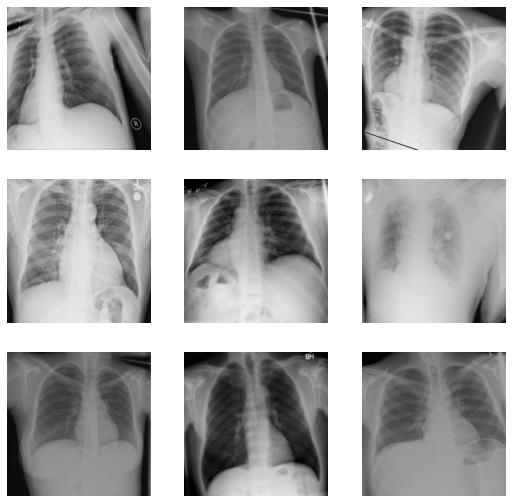

In [8]:
dls.show_batch()

In [9]:
learn = cnn_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), RocAucMulti(sigmoid=False)])

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

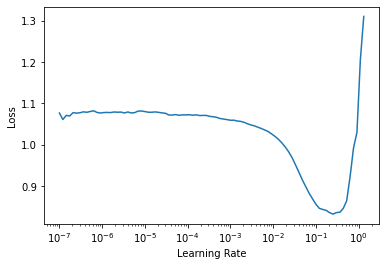

In [10]:
learn.lr_find()

In [11]:
lr = 3e-2

In [12]:
learn.fine_tune(2, 3e-2)

ValueError: Expected 2D array, got 1D array instead:
array=[10 10 10 ... 10 10 10].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
learn.show_results()

In [ ]:
learn.loss_func

In [ ]:
learn.model